# Setup

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image



In [10]:
iris = load_iris()
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
data.drop(columns=['sepal length (cm)', 'sepal width (cm)'], inplace=True)
display(data.target.value_counts())
data.head(2)

2.0    50
1.0    50
0.0    50
Name: target, dtype: int64

,petal length (cm),petal width (cm),target
0,1.4,0.2,0.0
1,1.4,0.2,0.0


In [11]:
X = data.drop(columns=['target']).values
y = data.target.values

# Decision Trees

## Overview

👍 Advantages

- No scaling necessary
- Resistant to outliers
- Intuitive and easy to interpret
- Allows for feature selection (see Gini-based feature_importance_)
- Non-linear modeling

👎 Disadvantages

- High variance (i.e. a small change in the data causes a big change in the tree's structure)
- Long training time if grown up to (large) max depth
- Splits data "orthogonally" to feature directions
    - 💡 use PCA upfront to "orient" data

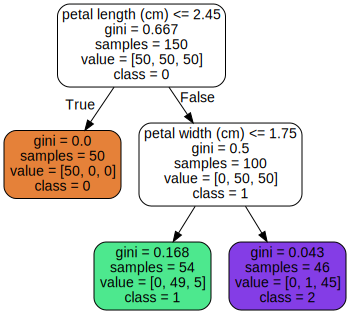

In [12]:
# Instantiate and train model
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=2)
tree_clf.fit(X,y)

# Export model graph
export_graphviz(tree_clf, out_file="iris_tree.dot", 
                feature_names=data.drop(columns=['target']).columns,
                class_names=['0','1','2'], 
                rounded=True, filled=True)

# Import model graph
with open("iris_tree.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

- Our Root Node splits the samples into 2 groups 
  - Petal length <= 2.45cm (50 samples)
  - Petal length > 2.45cm (100 samples)
- Resulting Left node has a gini of 0.0 
    - All samples belong to the same class (PURE)
    - Will not be split any futher
- Resulting Right node has a gini of 0.5 
    - Multiple classes contained in node (NOT PURE)
    - We will continue to split now at petal width <= 1.75

-------------------------------------------------------------

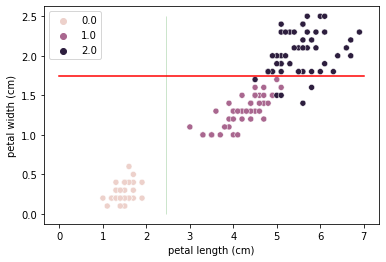

In [13]:
sns.scatterplot(x='petal length (cm)', y='petal width (cm)', hue='target', data=data)
sns.lineplot(x=[2.45,2.45], y=[0,2.5], color='g')
sns.lineplot(x=[0,7], y=[1.75,1.75], color='r');

## Overfitting

### NO RESTRICTIONS

- Split until all gini = 0

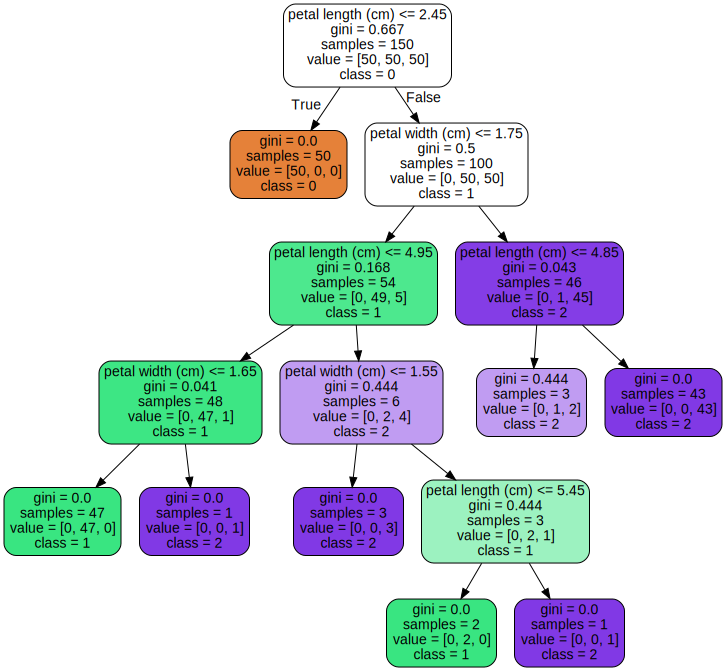

In [14]:
tree_clf = DecisionTreeClassifier(random_state=2)
tree_clf.fit(X,y)

export_graphviz(tree_clf, out_file="iris_tree_over_fit.dot", 
                feature_names=data.drop(columns=['target']).columns,
                class_names=['0','1','2'], 
                rounded=True, filled=True)

# Import model graph
with open("iris_tree_over_fit.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

### Min Samples Split

- If a node has less than the min threshold, it will not be split

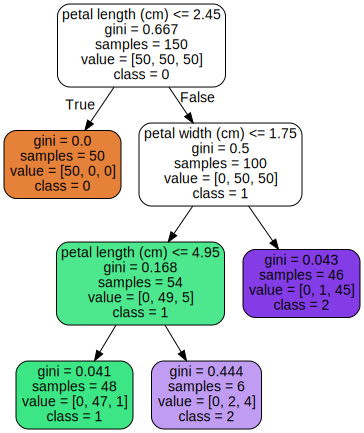

In [15]:
tree_clf = DecisionTreeClassifier(min_samples_split=50, random_state=2)
tree_clf.fit(X,y)

export_graphviz(tree_clf, out_file="iris_tree_min_split.dot", 
                feature_names=data.drop(columns=['target']).columns,
                class_names=['0','1','2'], 
                rounded=True, filled=True)

# Import model graph
with open("iris_tree_min_split.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

### Min Sample Leafs

- Min number of samples a resulting leaf must hold in order for split to occur

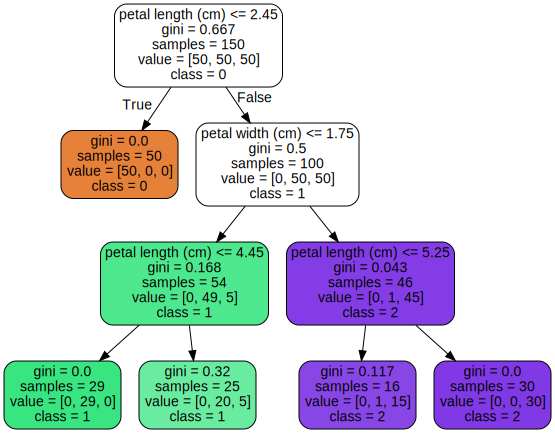

In [16]:
tree_clf = DecisionTreeClassifier(min_samples_leaf=15, random_state=2)
tree_clf.fit(X,y)

export_graphviz(tree_clf, out_file="iris_tree_min_leaf.dot", 
                feature_names=data.drop(columns=['target']).columns,
                class_names=['0','1','2'], 
                rounded=True, filled=True)

# Import model graph
with open("iris_tree_min_leaf.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

### Max Depth

- Total Number of Splits allowed

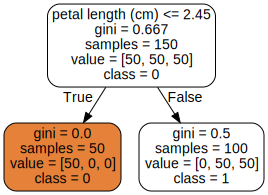

In [17]:
tree_clf = DecisionTreeClassifier(max_depth=1, random_state=2)
tree_clf.fit(X,y)

export_graphviz(tree_clf, out_file="iris_tree_max_depth.dot", 
                feature_names=data.drop(columns=['target']).columns,
                class_names=['0','1','2'], 
                rounded=True, filled=True)

# Import model graph
with open("iris_tree_max_depth.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

# Ensemble Methods

## Bagging (Bootstrap Aggregating)

👍 Advantages:

- Reduces variance (overfitting)
- Can be applied to any model

👎 Disadvantages

- Complex structure
- Long training time
- Disregards the performance of individual sub-models

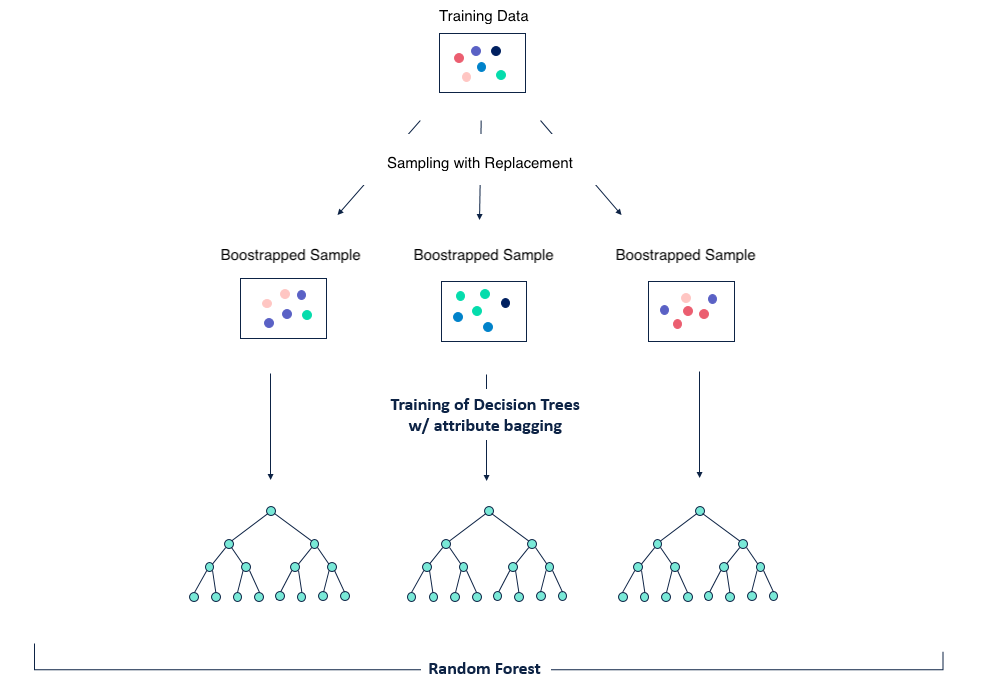

In [18]:
Image('random_forest.png')

### Bagging Trees --> Use Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier


cls = RandomForestClassifier(n_estimators=100, max_depth=5,oob_score=True)
cls.fit(X,y).oob_score_


0.9666666666666667

### Bagging other model types --> Use BaggingClassifier / Regressor

In [20]:
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier

weak_learner = KNeighborsClassifier(n_neighbors=3)
bagged_model = BaggingClassifier(weak_learner, n_estimators=40,oob_score=True)

bagged_model.fit(X,y).oob_score_

0.96

## Boosting

👍 Advantages:

- Strong sub-models have more influence in final decision
- Reduces bias

👎 Disadvantages:

- Computationally expensive (sequential)
- Easily overfits
- Sensitive to outliers (too much time spent trying to correctly predict them)

### ADA Boost

- all samples start with equal weight (new feature)
- any samples predicted incorrectly has weight increased
- any samples predicted corrected has weight decreased 
- next model fits with updated weights 
- repeat

### Gradient Boosting

Instead of changing weights for mis-classified samples
- new model trained on residual of the previous model
- add all the predictions for final result

Available with 
- Scikit-Learn GradientBoostingRegressor / Classifier
- xgboost XGBRegressor / Classifier

## Stacking

Train multiple different model types on full training set (no bagging)


- Give final prediction based on results from all different model predictions 
    - can add higher weights to specific model predictions or treat all equally

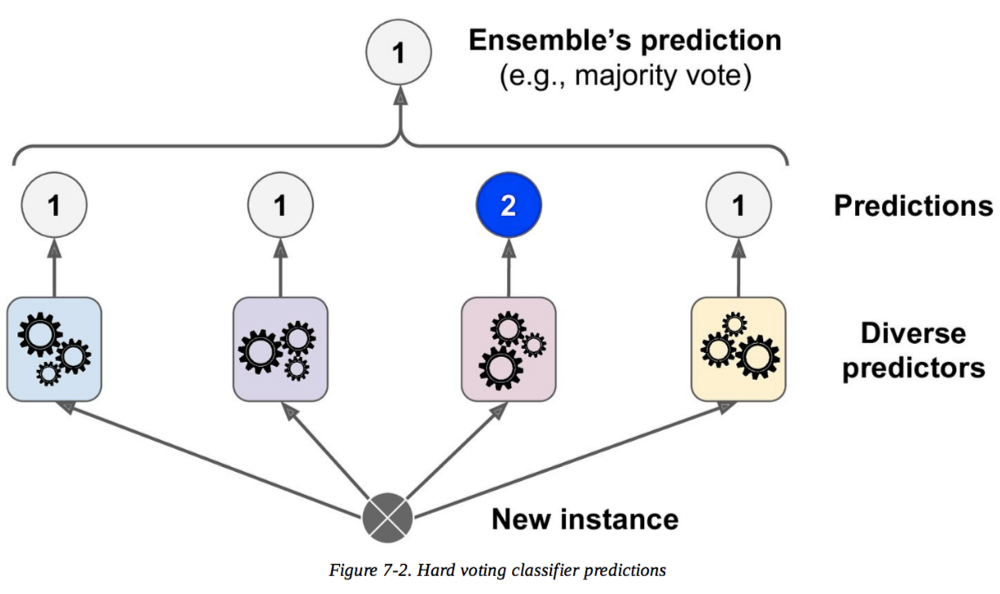

In [21]:
Image('simple_stack.png')

- OR Add final model and train only on sub models predictions (multi-layer)

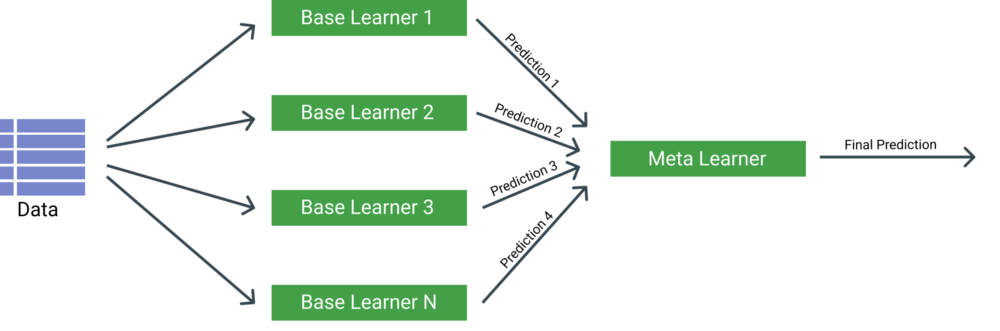

In [22]:
Image('multi_stack.png')